# Creating Images From Galaxy Particle distributions

In this example we show how to create various different types of images and maps from stellar particles. For this purpose we need a stellar distribution and a galaxy. The first section will handle this setup using a CAMELS galaxy, feel free to skip over this section to get to the imaging as the process is well documented elsewhere (e.g. the CAMELS [docs](../cosmo/cosmo_example.ipynb)).

## The setup

In [1]:
import time

import matplotlib.colors as cm
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import Planck18 as cosmo
from scipy import signal
from synthesizer.filters import FilterCollection as Filters
from synthesizer.grid import Grid
from synthesizer.kernel_functions import Kernel
from synthesizer.load_data.load_camels import load_CAMELS_IllustrisTNG
from unyt import Hz, erg, kpc, s

First port of call is initilaising the SPS grid. Here we use the test grid.

In [2]:
# Define the grid
grid_name = "test_grid"
grid_dir = "../../../tests/test_grid/"
grid = Grid(grid_name, grid_dir=grid_dir, new_lam=np.logspace(2, 5, 600))

For demonstration purposes we will just load one of the CAMELS galaxies from the test data. To see how to intialise your own galaxies see [the particle galaxy docs](../galaxies/galaxy_obj.ipynb).

In [3]:
galaxy_start = time.time()

# Create galaxy object
gal = load_CAMELS_IllustrisTNG(
    "../../../tests/data/",
    snap_name="camels_snap.hdf5",
    fof_name="camels_subhalo.hdf5",
    physical=True,
)[0]

print("Galaxy created, took:", time.time() - galaxy_start)

print(f"Galaxy has {gal.stars.nstars} stellar particles")
print(f"Galaxy gas {gal.gas.nparticles} gas particles")

Galaxy created, took: 0.0213162899017334
Galaxy has 473 stellar particles
Galaxy gas 0 gas particles


/opt/hostedtoolcache/Python/3.10.14/x64/lib/python3.10/site-packages/unyt/array.py:1949: RuntimeWarning: invalid value encountered in divide
  out_arr = func(


### Getting the spectra

To make an image we need to map the stellar particle properties onto the SPS grid defined in the `grid` object. To do this we use the galaxy's in built `generate_particle_spectra` method and create `"total"` SEDs with both stellar and nebular contributions. This returns an SED object containing lots of helper methods for working with spectra. 

Here we will use `get_fnu` to convert the rest frame SED into an observed SED which takes into account the previously set redshift stored on the `stars` object. By passing `igm=None` we assume the default `igm` contribution (`Inoue14`). This can be changed to `False` for no IGM or to another IGM model defined in `synthesizer.igm`.


In [4]:
spectra_start = time.time()

# Calculate the stellar rest frame SEDs for all particles in erg / s / Hz
sed = gal.stars.get_particle_spectra_incident(grid)

# Calculate the observed SED in nJy
sed.get_fnu(cosmo, gal.redshift, igm=None)

print("Spectra created, took:", time.time() - spectra_start)

Spectra created, took: 0.015304088592529297


### Defining filters

Next we need to define a set of filters we want photometric images for. This can be done in a number of ways using a `FilterCollection` (see the [filter docs](../filters.ipynb) for a full description). Here we will get Webb filters from the SVO database.

In [5]:
filter_start = time.time()

# Define filter list
filter_codes = [
    "JWST/NIRCam.F090W",
    "JWST/NIRCam.F150W",
    "JWST/NIRCam.F200W",
]

# Set up filter object
filters = Filters(filter_codes, new_lam=grid.lam)

print("Filters created, took:", time.time() - filter_start)

Filters created, took: 0.9589450359344482


### Getting photometry

Prior to making the image itself we need to get the luminosity in the filters we just defined. To do this we can use the `Sed` method to get photometry from a spectra. Here we are making images of the incident flux so we only need to get the photometry for that spectra.

In [6]:
phot_start = time.time()

gal.stars.particle_spectra["incident"].get_photo_luminosities(filters)

print("Photometry computed, took:", time.time() - phot_start)

Photometry computed, took: 0.0030777454376220703


## Imaging

The last step before we can make any images is to define the resolution of our images and the FOV (or width) of the images. These must have units associated to them to enable the code to internally transform all quantites to a consistent unit system.

In [7]:
# Define the width of the image
width = 30 * kpc

# Define image resolution (here we arbitrarily set it to 100
# pixels along an axis)
resolution = width / 200

print(
    "Image width is %.2f kpc with %.2f kpc resolution"
    % (width.value, resolution.value)
)

Image width is 30.00 kpc with 0.15 kpc resolution


## Photometric imaging

Now we have everything we need to make images. Although it is possible to work with the low level `ImageCollection` and `Image` methods we will here use the interface on a `Galaxy` to do everything. There are two of these helper methods, `get_imgs_luminosity` for luminosity images, and `get_imgs_flux` for flux images. We will focus on the former here.

The image helper methods both take the image properties we previously defined and a type of photometry for the image, these types can be any spectra for which you have calculated photometry, e.g. `"incident"`, `"intrinsic"`, or `"attenuated"`, for either stars (`stellar_photometry`) or black holes (`blackhole_photometry`). If both a stellar and black hole photometry type are passed then an image is made for each component before they are combined and returned.

Images can either be simple 2D histograms or the particles can be smoothed over their kernels. What type of image is made is controlled by the `img_type` argument. Below we demonstrate both approaches, however, for the latter we also need to define a kernel, which we have already imported from the `kernel_functions` module.

In [8]:
img_start = time.time()

# Get the SPH kernel
sph_kernel = Kernel()
kernel_data = sph_kernel.get_kernel()

# Get the image
hist_imgs = gal.get_images_luminosity(
    resolution,
    fov=width,
    img_type="hist",
    stellar_photometry="incident",
    blackhole_photometry=None,
)

# Get the image
smooth_imgs = gal.get_images_luminosity(
    resolution,
    fov=width,
    img_type="smoothed",
    stellar_photometry="incident",
    blackhole_photometry=None,
    kernel=kernel_data,
    kernel_threshold=1,
)

print("Images took:", time.time() - img_start)

Images took: 0.09109926223754883


When making images in multiple bands the image arrays themselves are stored on the returned `ImageCollection` in a dictionary called `imgs` of the form `{filter_code: Image}`, where an `Image` is a container including the image array itself (`arr`), unit information (`units`) and the `resolution` and `fov` of the image. An Image also includes a number of different methods for manipulating and visuallising individual `Image`s. 

Below we will extract this dictionary and plot each of the images we have made.

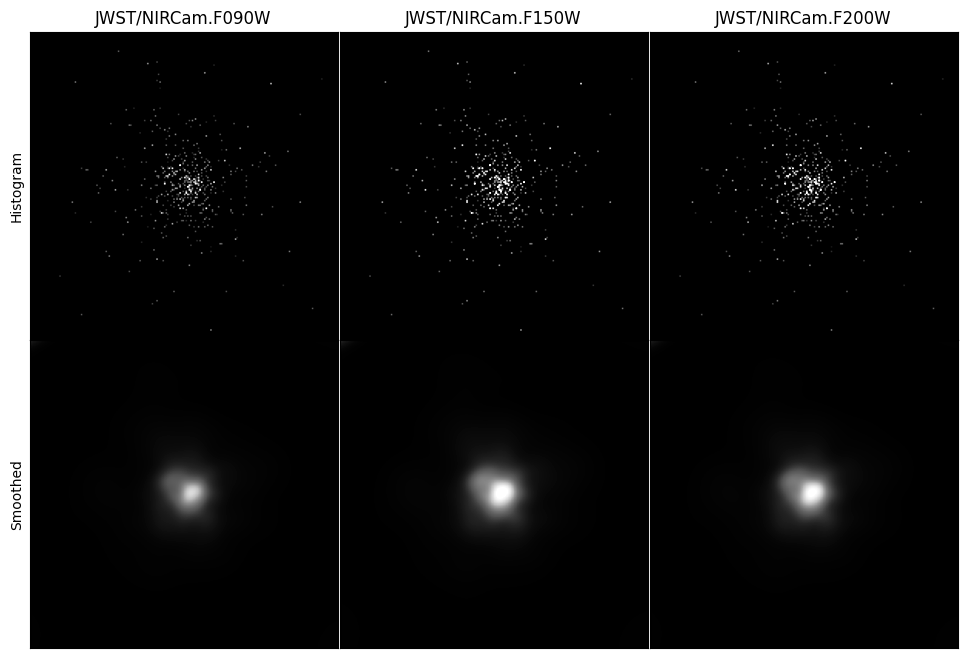

In [9]:
# Lets set up a simple normalisation across all images
vmax = 0
for img in hist_imgs.values():
    up = np.percentile(img.arr, 99.9)
    if up > vmax:
        vmax = up
hist_norm = cm.Normalize(vmin=0, vmax=vmax)
vmax = 0
for img in smooth_imgs.values():
    up = np.percentile(img.arr, 99.9)
    if up > vmax:
        vmax = up
smooth_norm = cm.Normalize(vmin=0, vmax=vmax)


# Set up plot
fig = plt.figure(figsize=(4 * len(filters), 4 * 2))
gs = gridspec.GridSpec(2, len(filters), hspace=0.0, wspace=0.0)

# Create top row
axes = []
for i in range(len(filters)):
    axes.append(fig.add_subplot(gs[0, i]))

# Loop over images plotting them
for ax, fcode in zip(axes, filter_codes):
    ax.imshow(hist_imgs[fcode].arr, norm=hist_norm, cmap="Greys_r")
    ax.set_title(fcode)
    ax.tick_params(
        axis="both",
        which="both",
        left=False,
        right=False,
        labelleft=False,
        labelright=False,
        bottom=False,
        top=False,
        labelbottom=False,
        labeltop=False,
    )

# Set y axis label on left most plot
axes[0].set_ylabel("Histogram")

# Create bottom row
axes = []
for i in range(len(filters)):
    axes.append(fig.add_subplot(gs[1, i]))

# Loop over images plotting them
for ax, fcode in zip(axes, filter_codes):
    ax.imshow(smooth_imgs[fcode].arr, norm=smooth_norm, cmap="Greys_r")
    ax.tick_params(
        axis="both",
        which="both",
        left=False,
        right=False,
        labelleft=False,
        labelright=False,
        bottom=False,
        top=False,
        labelbottom=False,
        labeltop=False,
    )

# Set y axis label on left most plot
axes[0].set_ylabel("Smoothed")

# Plot the image
plt.show()
plt.close(fig)

## Applying a Point Spread Function (PSF)

Of course, the smoothed distribution is only part of the story. To properly model observations by a particular observatory we need to take into account the smoothing due to the PSF of the telescope. 

To apply a PSF we can either use `Image.apply_psf` on individual `Image` objects or apply a dictionary of PSFs of the form `{filter_code: psf_array}`, to each image in an `ImageCollection` with the `apply_psfs` method. Here we will just create a fake gaussian PSF for all filters but PSFs can be sourced however the user wishes (for Webb we recommend the _webbpsf_ package) as long as a simple numpy array is passed within the psf dictionary for each filter.

To get the most accurate result from the PSF convolution it is recommended to do the convolution on a super sampled image. Although we will here just supersample the images we just made, it is recommended to first make the images at the super sampled resolution and then subsequently downsample after the fact. 

In [10]:
# Create a fake PSF for each filter
psf = np.outer(
    signal.windows.gaussian(100, 3), signal.windows.gaussian(100, 3)
)
psfs = {f: psf for f in filters.filter_codes}

img_start = time.time()

# Supersample the image
smooth_imgs.supersample(2)

# Apply the PSFs
psf_imgs = smooth_imgs.apply_psfs(psfs)

# And downsample back to the native resolution
smooth_imgs.downsample(0.5)
psf_imgs.downsample(0.5)

print("PSF images made, took:", time.time() - img_start)

PSF images made, took: 0.08199262619018555


`apply_psfs` returns a new `ImageCollection` containing the newly convolved `Image`s. We can now use the plotting helper function to plot these images with some normalisation.

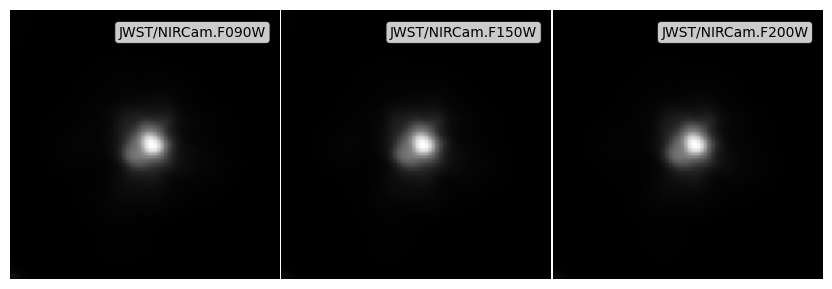

In [11]:
# Lets set up a simple normalisation across all images
vmax = 0
for img in psf_imgs.values():
    up = np.percentile(img.arr, 99.9)
    if up > vmax:
        vmax = up

# Get the plot
fig, ax = psf_imgs.plot_images(show=True, vmin=0, vmax=vmax)
plt.close(fig)

## Applying noise

The final ingredient for a fully forward modelled synthetic image is a noise field. We include 4 different to approaches to include noise: 
- `apply_noise_array`: Add an exist noise field/array.
- `apply_noise_from_std`: Derive a noise distribution, centered on 0, from a user specified standard deviation, and then generate and add a noise array. 
- `apply_noise_from_snr` (aperture): Derive a noise distribution from a Signal-to-Noise Ratio (SNR), defined in an aperture with size `aperture_radius` and a specified `depth`. This will derive the standard deviation of the nosie distribution assuming $SNR= S / \sigma$ for an aperture before deriving the per pixel noise, computing the noise array and adding it.
- `apply_noise_from_snr` (point source): Derive a noise distribution from a SNR and depth. This will derive the standard deviation of the noise distribution assuming $SNR= S / \sigma$ for a pixel before computing the noise array and adding it. This behaviour can be achieved by omitting `aperture_radius` in the call to `apply_noise_from_snr`
    
As with applying a PSF, these methods have singular versions (as listed above) which can be used on an individual `Image` and pluralised versions on an `ImageCollection` which take dictionaries for each of the arguments. 

If an image has units then the passed `noise_arr` or `noise_std` must also have units.

Applying noise with any of the methods described above will return a new `ImageCollection`/`Image` contain the noisy image. In addition to the noisy image (stored under `Image.arr`) the new `Image` (or the new `Image`s within an `ImageCollection`) will contain the noise array stored in the `noise_arr` attribute and the weight map stored in the `weight_map` attribute on the `Image`.

Below we demonstrate each method using the `ImageCollection` interface. We will not explictly show the noise and weight maps but know they are there if you need them (at `Image.noise_arr` and `Image.weight_map`).

### Noise arrays

Noisy images made, took: 0.014585256576538086


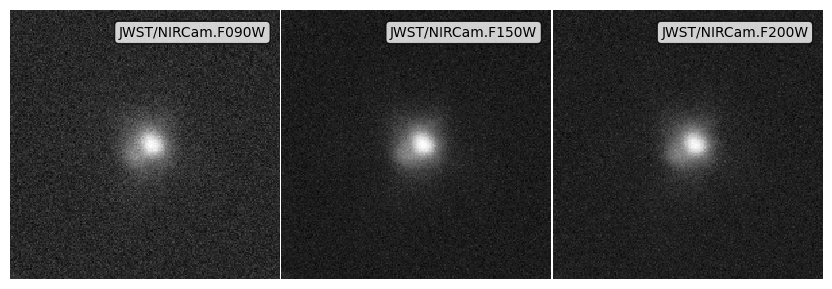

In [12]:
img_start = time.time()

# Get a noise array for each filter
noises = {
    f: np.random.normal(loc=0, scale=10**26.0, size=(psf_imgs.npix))
    * erg
    / s
    / Hz
    for f in psf_imgs.keys()
}

# Apply the noise array
noise_array_imgs = psf_imgs.apply_noise_arrays(noises)

print("Noisy images made, took:", time.time() - img_start)

# Get the plot
fig, ax = noise_array_imgs.plot_images(show=True, vmin=0, vmax=vmax)
plt.close(fig)

### Noise from standard deviations

Noisy images made, took: 0.0066547393798828125


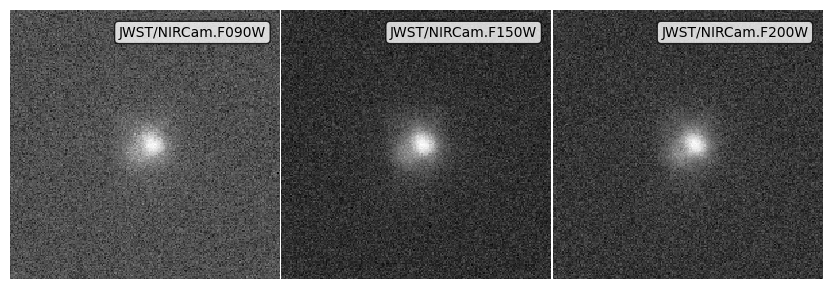

In [13]:
img_start = time.time()

# Get a noise standard deviation for each filter
noise_stds = {f: 10**26.3 * erg / s / Hz for f in psf_imgs.keys()}

# Apply the noise array
noise_std_imgs = psf_imgs.apply_noise_from_stds(noise_stds)

print("Noisy images made, took:", time.time() - img_start)

# Get the plot
fig, ax = noise_std_imgs.plot_images(show=True, vmin=0, vmax=vmax)
plt.close(fig)

### Noise from an aperture depth

Noisy images made, took: 0.1543264389038086


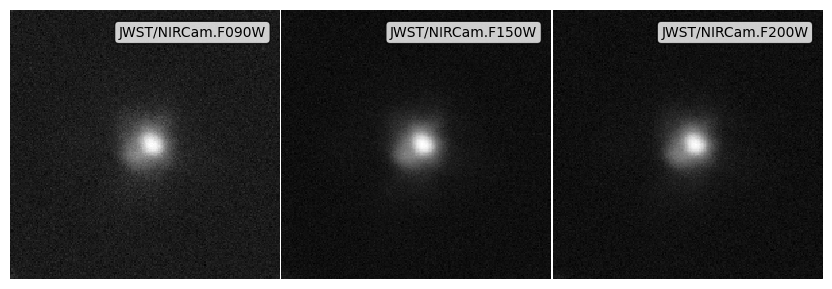

In [14]:
# Get dictionaries with the noise properties for each filter
snrs = {f: 5 for f in psf_imgs.keys()}
depths = {f: 10**28.0 * erg / s / Hz for f in psf_imgs.keys()}

# Apply the noise array
noise_app_imgs = psf_imgs.apply_noise_from_snrs(
    snrs=snrs, depths=depths, aperture_radius=0.5 * kpc
)

print("Noisy images made, took:", time.time() - img_start)

# Get the plot
fig, ax = noise_app_imgs.plot_images(show=True, vmin=0, vmax=vmax)
plt.close(fig)

### Noise from point source depth

Noisy images made, took: 0.2976508140563965


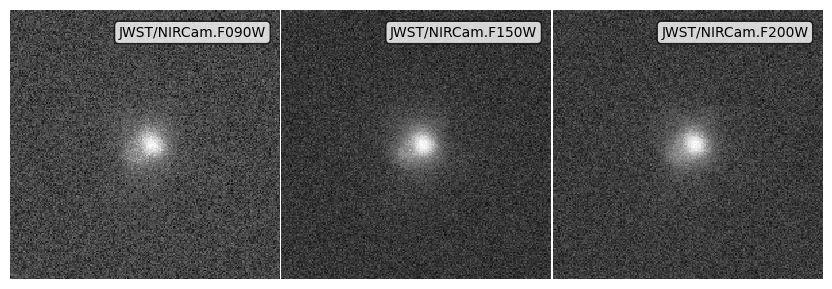

In [15]:
# Get dictionaries with the noise properties for each filter
snrs = {f: 5 for f in psf_imgs.keys()}
depths = {f: 10**27.0 * erg / s / Hz for f in psf_imgs.keys()}

# Apply the noise array
noise_ps_imgs = psf_imgs.apply_noise_from_snrs(snrs=snrs, depths=depths)

print("Noisy images made, took:", time.time() - img_start)

# Get the plot
fig, ax = noise_ps_imgs.plot_images(show=True, vmin=0, vmax=vmax)
plt.close(fig)

## Making an RGB image

Finally we can use the RGB image method on the `ImageCollection` to make quick RGB images by simply providing a dictionary detailing which filters we want in which bands and optional weights for each filter which we will ignore here.

Scaling to: 6.413412391057469e+25 -> 3.025188499359762e+27
(200, 200, 3)


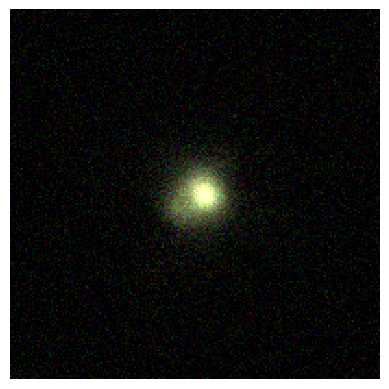

In [16]:
# Create the rgb image from the psf image above example using our 3 filters
rgb_img = noise_ps_imgs.make_rgb_image(
    rgb_filters={
        "R": [
            "JWST/NIRCam.F200W",
        ],
        "G": [
            "JWST/NIRCam.F150W",
        ],
        "B": [
            "JWST/NIRCam.F090W",
        ],
    },
)

# Set up minima and maxima
vmin = -np.percentile(rgb_img, 32)
vmax = np.percentile(rgb_img, 99.9)
norm = cm.Normalize(vmin=vmin, vmax=vmax, clip=True)
print("Scaling to:", vmin, "->", vmax)

# Normalise the image.
rgb_img = norm(rgb_img)

print(rgb_img.shape)

# Plot the image
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(rgb_img, origin="lower", interpolation="nearest")
ax.axis("off")
plt.show()
plt.close(fig)